In [1]:
from os import listdir, path
import mne
import matplotlib
import meegkit
import numpy as np
import math
import pyriemann
import picard
%matplotlib qt

dirData = 'G:\Expé\ANITI\Data'
# np.set_printoptions(threshold=np.inf)

## SNR function

In [2]:
def SNR(x, y=None, axis=0):
    """Signal to Noise Ratio, as defined here:
    www.scholarpedia.org/article/Signal-to-noise_ratio_in_neuroscience

    This is equivalent to the variance of the average signal in relation to the 
    total variance.

    Parameters
    ----------
    x : array of any shape
        An array representing a set of signals. The last dimension in the array
        must correspond to the time course of the signal (over which the common
        underlying signal is expected).
    y : None, array of shape == x.shape
        Reference array that will be used for computation of the underlying
        signal. If y = None, x is used as reference array. Defaults to None.
    axis : int or tuple of ints
        The axes over which the signals should be averaged to get the common
        underlying signal. Can include every axis of the array except for the 
        last one, which is assumed to be the time axis of the signal.
        Defaults to 0.

    Returns
    -------
    SNR : float or array of floats
        The signal-to-noise ration over the remaining axes. Is equivalent to 
        the fraction of how much of the total variance in the signal set is
        explained through the common underlying signal.
    """
    y = x if y is None else y
    axis = tuple([axis]) if isinstance(axis, int) else axis
    if np.any([ax in axis for ax in [-1, x.ndim - 1]]):
        raise ValueError("Last array axis can't be passed as axis argument.")
    return np.mean(np.mean(y, axis)**2, axis=-1) / np.var(x, axis=(-1,) + axis)

## Subject definition

In [3]:
SUBJ_tot = ['PCB0805', 'PEJ0511', 'PMFH0507', 'PND1607', 'PSV2801', 'PJFS0801',\
            'PMF0711', 'PSL2804', 'PEF0102', 'PJE0610', 'PLD2501', 'PZG0801',\
            'PZG2305', 'PBJ0703', 'PAI0912', 'PAS0505', 'PJJTT0601', 'POL3007',\
            'PVB2304', 'PMR1501', 'PCH0107', 'PNP1504', 'PTH1804', 'PCD0306']
SUBJ = ['PCB0805'] #Subject to analyse. change to participant name if necessary
SUBJ_rej = ['PRS1907'] #Subjects to reject 

fEEG = [] #list of filenames to read

for iDir in SUBJ:
    if path.isdir(path.join(dirData, 'sub-'+iDir)):
        filename = path.join(dirData, 'sub-'+ iDir + '\ses-S001\eeg\sub-'+iDir+'_ses-S001_task-Default_run-001_eeg.set')
        fEEG.append(filename)
        print('Reading '+filename)
    else:
        print('No participant '+iDir)

Reading G:\Expé\ANITI\Data\sub-PCB0805\ses-S001\eeg\sub-PCB0805_ses-S001_task-Default_run-001_eeg.set


In [4]:
#Loading eeglab data
for iEEG in fEEG:
    EEG_raw = mne.io.read_raw_eeglab(filename, preload = True, verbose=False)
EEG_raw.info
# EEG_raw.plot(duration = 5, n_channels = EEG_raw.info['nchan'])
#High pass filtering for drift and DC offset removal
l_freq = 0.1
EEG_filt = EEG_raw.copy().filter(l_freq= l_freq, h_freq = None)

#Line noise removal
tmpEEG, _ = meegkit.dss.dss_line(EEG_filt.get_data().T, 50, EEG_filt.info['sfreq'])
EEG_filt_LN = mne.io.RawArray(tmpEEG.T, EEG_filt.info)
# EEG_filt_LN = EEG_filt

#Rereferencing to TP9/TP10 (better for DTF than average referencing)
EEG_reref = EEG_filt_LN.copy().set_eeg_reference(ref_channels=['TP9', 'TP10'])

#Bad  channel removal and interpolation (spherical spline)
EEG_interp = EEG_reref.copy().interpolate_bads(reset_bads=False)


Power of components removed by DSS: 0.96
Creating RawArray with float64 data, n_channels=64, n_times=2122493
    Range : 0 ... 2122492 =      0.000 ...  4244.984 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<ipython-input-4-f33601ac76ee>:19: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  EEG_interp = EEG_reref.copy().interpolate_bads(reset_bads=False)


In [5]:
#Define the windows for asr calibration
#takes 1 minute before each trial beginning (event: 15 --> post-instructions)
#gets the SNR over each window and select the highest SNRed-window as ASR calibration
wSNR = []
event_types = ['10', '101', '102', '103', '104', '108', '109', '11', '110', '112', '114', '115', '116', '119', '12', '120',\
               '121', '13', '14', '15', '20', '40', '5', '50', '52', '60', '70']
custom_dict = {}
for iType in event_types:
    custom_dict[iType] = int(iType)
events_from_annot, dictio = mne.events_from_annotations(EEG_raw, event_id = custom_dict)
events_15 = mne.pick_events(events_from_annot, include = 15)
for iStamp in events_15[:,0]:
    try:
        #get the time stamp (in seconds) of the beginning of the 1-min window
        tmin = math.floor(iStamp/EEG_raw.info['sfreq']-60)
        #get the SNR during the time window [start-1min:start]
        wSNR.append(SNR(EEG_interp.copy().crop(tmin = tmin, tmax = math.floor(iStamp/EEG_raw.info['sfreq'])).get_data()))  
    except ValueError:
        wSNR.append(0) #if not enough data in the preceeding window: SNR=0
        continue
#get the event for which the SNR is highest in the preceeding time window
tcalib = events_15[wSNR.index(max(wSNR)),0]

#Select this window as calibration data for ASR
#(Riemannian) ASR
#win_len should be higher than 1.5*nchan
#win_overlap is 0.5 in eeglab but higher ensures that fewer artifact portions are going to be missed

defASR = meegkit.asr.ASR(sfreq=EEG_interp.info['sfreq'], cutoff=5, blocksize=100,\
                          win_len=max(0.5, 1.5*EEG_interp.info['nchan']/EEG_interp.info['sfreq']),\
                          win_overlap=0.66, max_dropout_fraction=0.1, min_clean_fraction=0.25, \
                          name='asrfilter', method='riemann', estimator='lwf')
defASR.fit(EEG_interp.get_data()[:, int(tcalib-60*EEG_interp.info['sfreq']):tcalib])



Used Annotations descriptions: ['10', '101', '102', '103', '104', '108', '109', '11', '110', '112', '114', '115', '116', '119', '12', '120', '121', '13', '14', '15', '20', '40', '5', '50', '52', '60', '70']


(array([[ 6.64271088e-06,  1.51283047e-06, -1.11831146e-06, ...,
          2.12502642e-05,  1.50847069e-05,  1.33578101e-05],
        [ 2.47935888e-05,  2.03179463e-05,  2.00720076e-05, ...,
          1.49751536e-05,  1.60373030e-05,  1.75505658e-05],
        [ 2.87250722e-05,  2.43065713e-05,  2.24494455e-05, ...,
         -4.80690854e-06, -3.80192886e-06, -2.52727075e-06],
        ...,
        [ 3.21903462e-05,  2.87322614e-05,  3.08799767e-05, ...,
          1.21729791e-05,  1.44730939e-05,  1.26339593e-05],
        [ 2.71790294e-05,  2.49487259e-05,  2.40250169e-05, ...,
         -2.42175285e-06, -2.17762629e-06, -2.24042036e-07],
        [ 1.83551644e-05,  1.40988031e-05,  1.26315228e-05, ...,
          1.61138117e-05,  1.69998755e-05,  1.77929555e-05]]),
 array([[ True,  True,  True, ..., False, False, False]]))

In [6]:
EEG_ASR = EEG_interp.copy()
wind_EEG = meegkit.utils.matrix.sliding_window(EEG_ASR.get_data(), window=int(EEG_ASR.info['sfreq']), step=int(EEG_ASR.info['sfreq']))
tmpEEG = np.zeros_like(wind_EEG)
for iWind in range(wind_EEG.shape[1]):
    tmpEEG[:,iWind,:] = defASR.transform(wind_EEG[:, iWind, :])
    if (iWind%50)==0: #Prints output every 50 step to see the advances
        print('Window {} out of {}'.format(iWind, wind_EEG.shape[1]))

EEG_ASR._data = tmpEEG.reshape(EEG_ASR.info['nchan'], -1)

Window 0 out of 4244
Window 50 out of 4244
Window 100 out of 4244
Window 150 out of 4244
Window 200 out of 4244
Window 250 out of 4244
Window 300 out of 4244
Window 350 out of 4244
Window 400 out of 4244
Window 450 out of 4244
Window 500 out of 4244
Window 550 out of 4244
Window 600 out of 4244
Window 650 out of 4244
Window 700 out of 4244
Window 750 out of 4244
Window 800 out of 4244
Window 850 out of 4244
Window 900 out of 4244
Window 950 out of 4244
Window 1000 out of 4244
Window 1050 out of 4244
Window 1100 out of 4244
Window 1150 out of 4244
Window 1200 out of 4244
Window 1250 out of 4244
Window 1300 out of 4244
Window 1350 out of 4244
Window 1400 out of 4244
Window 1450 out of 4244
Window 1500 out of 4244
Window 1550 out of 4244
Window 1600 out of 4244
Window 1650 out of 4244
Window 1700 out of 4244
Window 1750 out of 4244
Window 1800 out of 4244
Window 1850 out of 4244
Window 1900 out of 4244
Window 1950 out of 4244
Window 2000 out of 4244
Window 2050 out of 4244
Window 2100 out

In [15]:
EEG_ASR.save(path.join(dirData, 'EEG_ASR_raw.fif'), picks=None, tmin=0, tmax=None, proj=False, fmt='double', overwrite=False)
EEG_ASR = mne.io.read_raw(path.join(dirData, 'EEG_ASR_raw.fif'), preload = True)

Writing G:\Expé\ANITI\Data\EEG_ASR_raw.fif
Closing G:\Expé\ANITI\Data\EEG_ASR_raw.fif
[done]
Opening raw data file G:\Expé\ANITI\Data\EEG_ASR_raw.fif...
    Range : 0 ... 2121999 =      0.000 ...  4243.998 secs
Ready.
Reading 0 ... 2121999  =      0.000 ...  4243.998 secs...
63 28


In [6]:
EEG_ASR = mne.io.read_raw(path.join(dirData, 'EEG_ASR_raw.fif'), preload = True)
rank1 = mne.compute_rank(EEG_ASR)
rank2 = mne.compute_rank(EEG_interp)
Rank = min(rank1['eeg'], rank2["eeg"])
#Definition de l'ICA
defICA = mne.preprocessing.ICA(n_components=Rank, noise_cov=None, random_state=None, method='picard', max_iter=500, verbose=True)
defICA.fit(EEG_ASR)
# defICA.plot_sources(EEG_ASR)
n_ic = int(EEG_ASR.info['nchan']/5)
defICA.plot_properties(EEG_ASR, range(n_ic))

Opening raw data file G:\Expé\ANITI\Data\EEG_ASR_raw.fif...
    Range : 0 ... 2121999 =      0.000 ...  4243.998 secs
Ready.
Reading 0 ... 2121999  =      0.000 ...  4243.998 secs...
Computing rank from data with rank=None
    Using tolerance 7.9e-10 (2.2e-16 eps * 64 dim * 5.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
    Using tolerance 1e-09 (2.2e-16 eps * 64 dim * 7.3e+04  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 0 projectors
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 63 components


<ipython-input-6-67959446f355>:7: RuntimeWarning: Using n_components=63 (resulting in n_components_=63) may lead to an unstable mixing matrix estimation because the ratio between the largest (38) and smallest (1.7e-11) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 62
  defICA.fit(EEG_ASR)


Fitting ICA took 2402.8s.


<ICA | raw data decomposition, fit (picard): 2122000 samples, 63 components, channels used: "eeg">

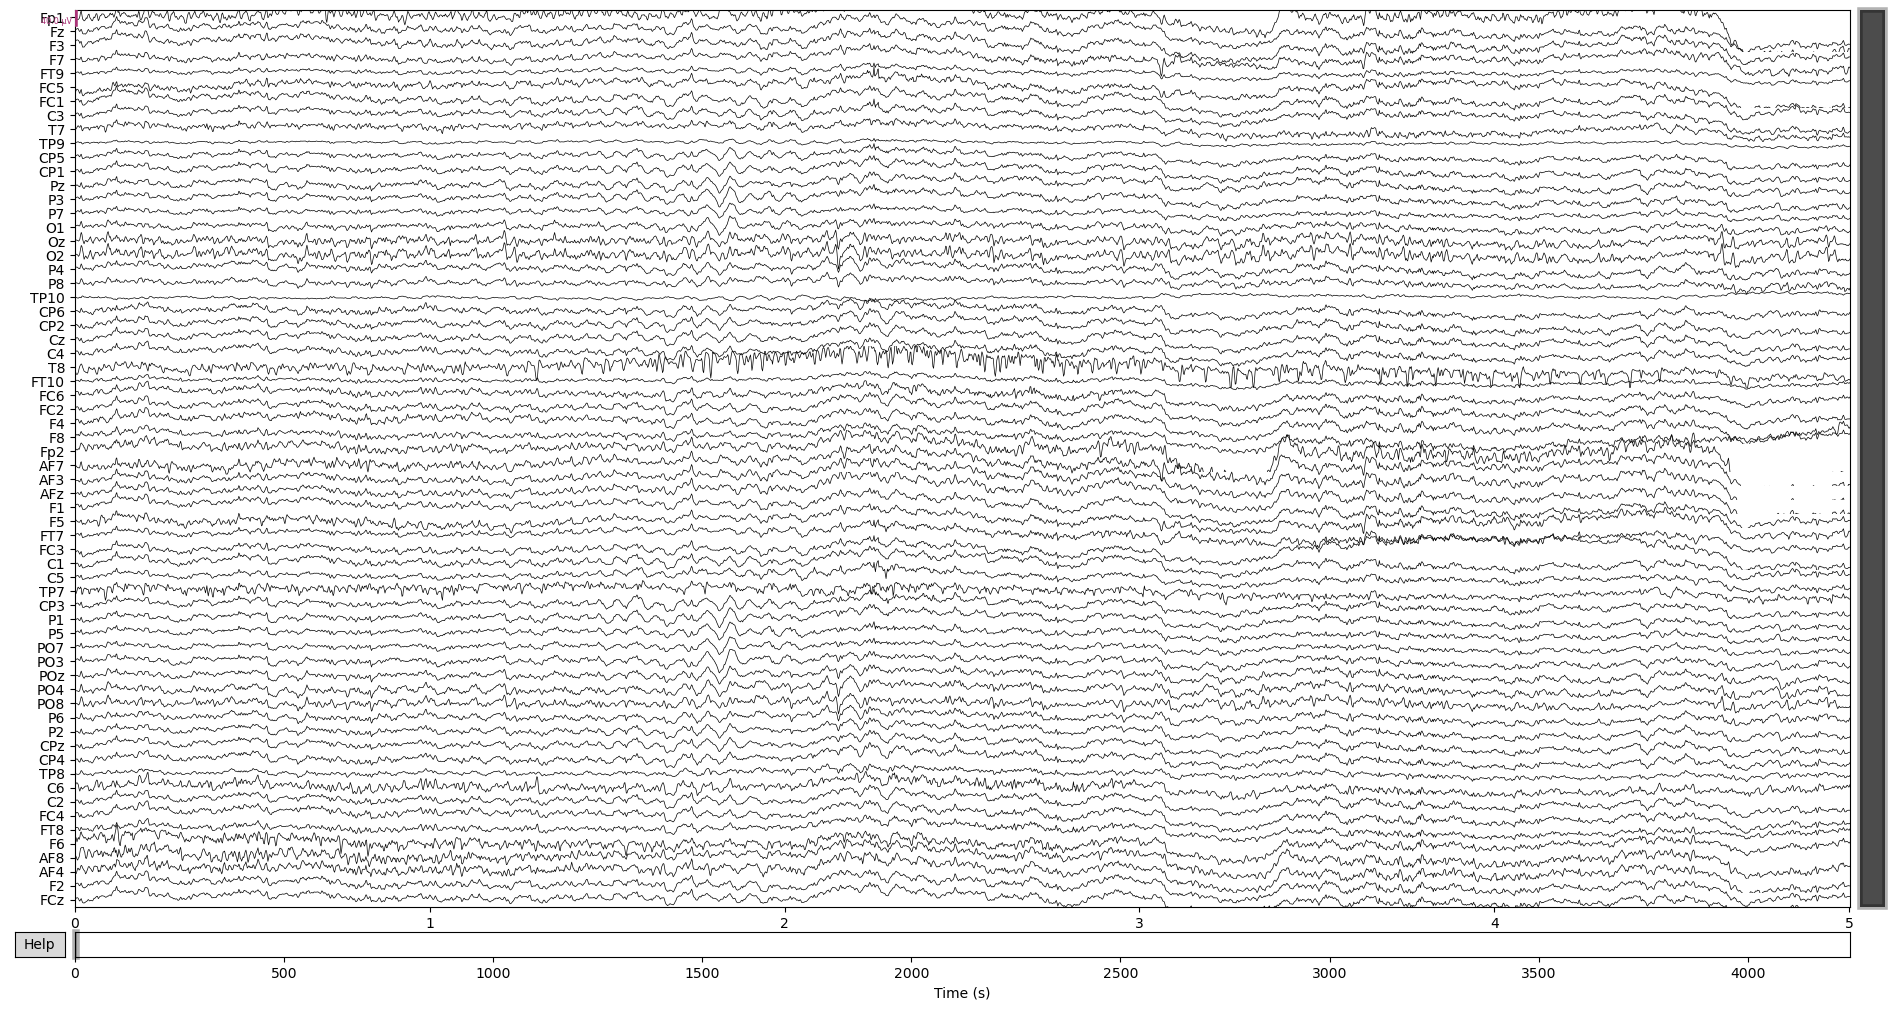

Channels marked as bad: none


In [24]:
EEG_ASR.plot(duration = 5, n_channels = EEG_ASR.info['nchan'])

In [19]:
EEG_ASR.ev

KeyError: 'ref'

In [4]:
#Definition de l'ICA
defICA = mne.preprocessing.ICA(n_components=Rank, noise_cov=None, random_state=None, method='picard', max_iter=500, verbose=True)
# EEG_ASR._data = .transform(EEG_interp.get_data())[:, int(EEG_ASR.info['sfreq']*0.25):]

NameError: name 'EEG_interp' is not defined

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>

In [43]:
l_freq = 0.1
h_freq = 40
sfreq = info['sfreq']
EEG_filt = EEG.filter(l_freq= l_freq, h_freq = h_freq)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (33.002 sec)



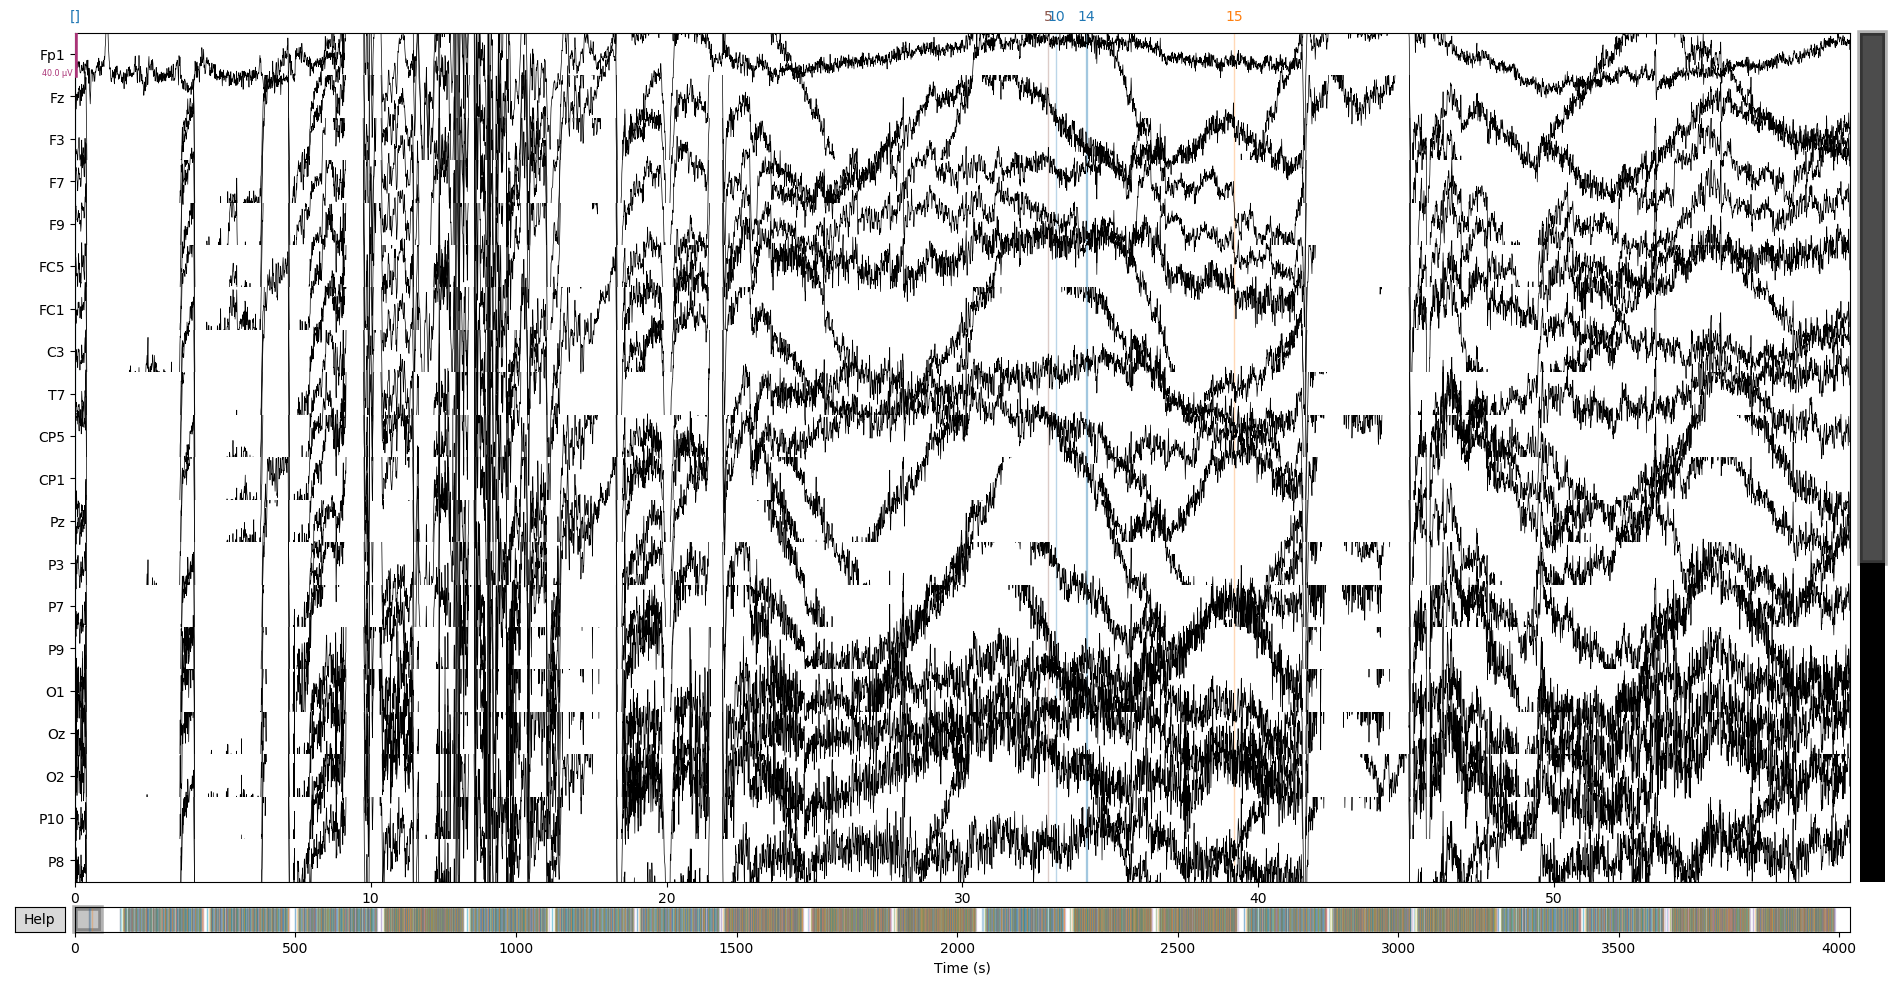

Channels marked as bad: none
Channels marked as bad: none


In [32]:
EEG.plot(duration=60)
EEG_filt.plot(duration=60)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


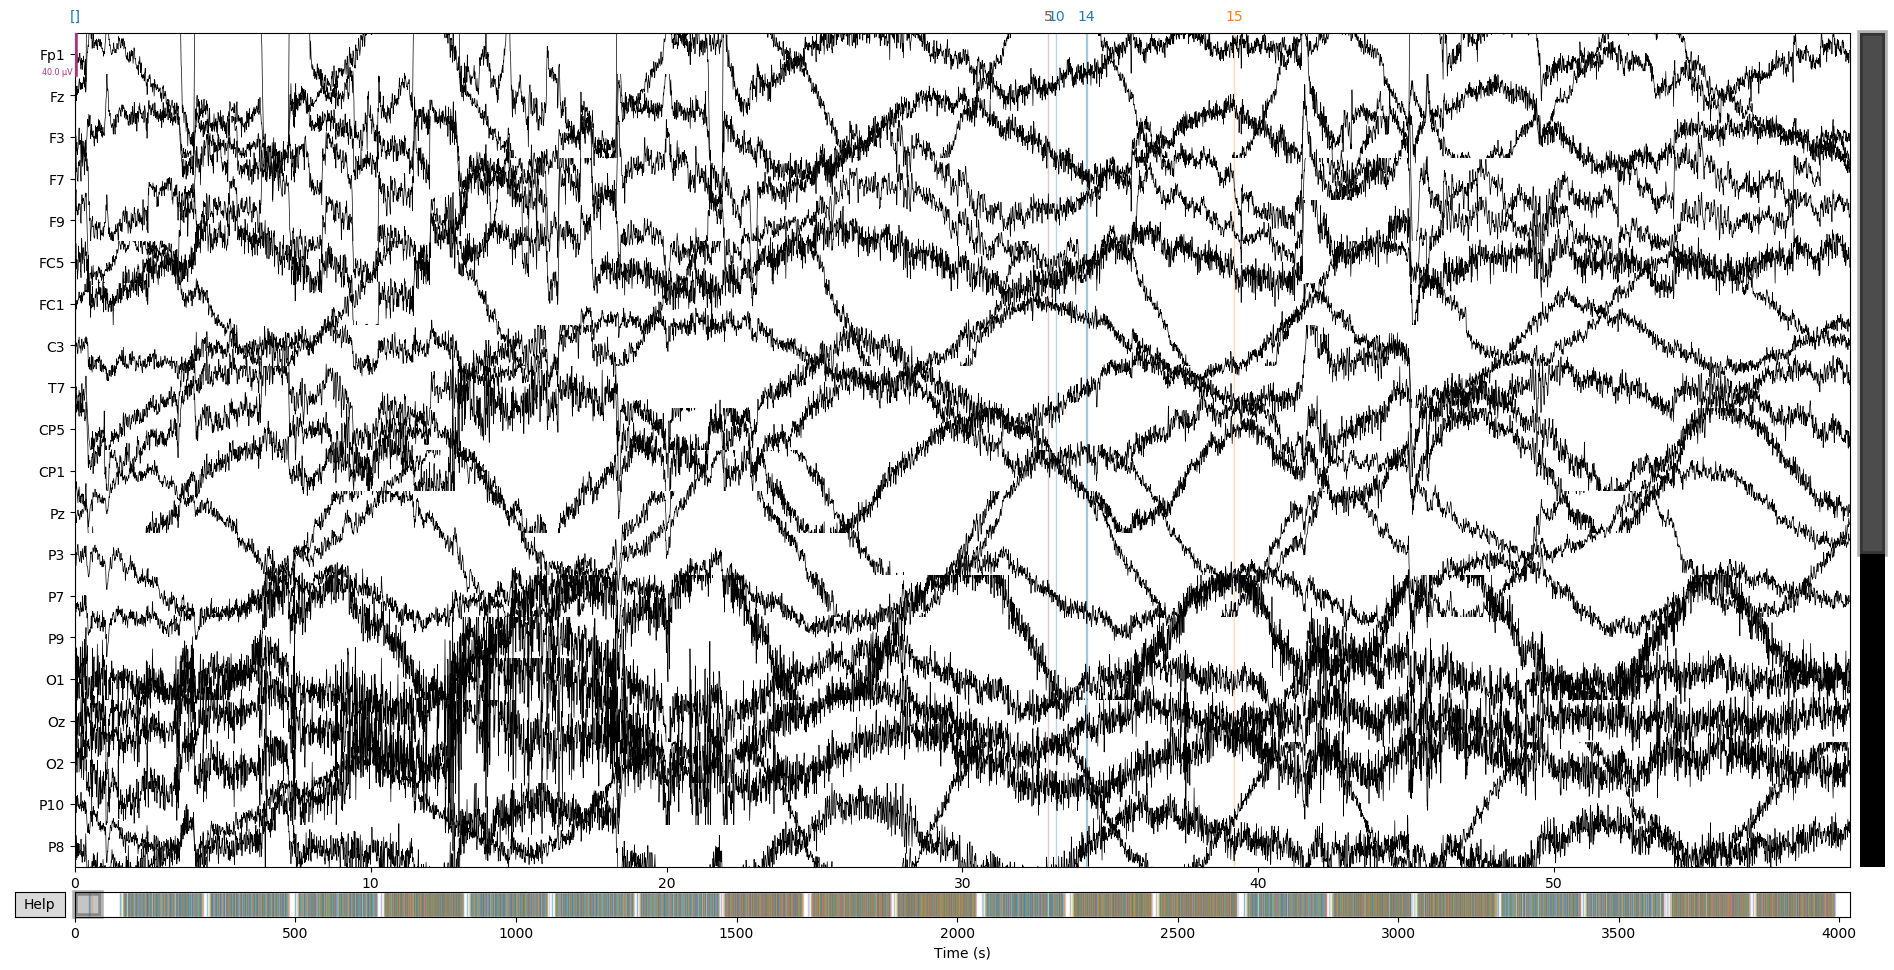

In [50]:
EEG_reref = EEG_filt.copy().set_eeg_reference(ref_channels='average')
EEG_reref.plot(duration=60)

In [57]:
events = EEG.annotations
(events,
 event_dict) = mne.events_from_annotations(EEG)

Used Annotations descriptions: ['10', '101', '102', '103', '104', '108', '109', '11', '110', '112', '114', '115', '116', '119', '12', '120', '121', '13', '14', '15', '20', '40', '5', '50', '52', '60', '70', '[]']


In [59]:
event_id, tmin, tmax = {'60'}, -0.2, 1
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax)
epochs = mne.Epochs(EEG_reref, **epochs_params).average()

TypeError: event_id must be an int, got <class 'set'>